In [1]:
from scipy.io import wavfile
import numpy as np
#import pickle
import os
import glob
import time
import write_op as wo
from data_set_params import DataSetParams
#import sys
import tensorflow as tf
#from tensorflow.keras import models, layers, regularizers
from helper_fns import compute_features, nms_1d, gen_spectrogram, process_spectrogram
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
def read_audio(file_name, do_time_expansion, chunk_size, win_size):

    # try to read in audio file
    try:
        samp_rate_orig, audio = wavfile.read(file_name)
    except:
        print('  Error reading file')
        return True, None, None, None, None

    # convert to mono if stereo
    if len(audio.shape) == 2:
        print('  Warning: stereo file. Just taking right channel.')
        audio = audio[:, 1]
    file_dur = audio.shape[0] / float(samp_rate_orig)
    print('  dur', round(file_dur,3), '(secs) , fs', samp_rate_orig)

    # original model is trained on time expanded data
    samp_rate = samp_rate_orig
    if do_time_expansion:
        samp_rate = int(samp_rate_orig/10.0)
        file_dur *= 10

    # pad with zeros so we can go right to the end
    multiplier = np.ceil(file_dur/float(chunk_size-win_size))
    diff       = multiplier*(chunk_size-win_size) - file_dur + win_size
    audio_pad  = np.hstack((audio, np.zeros(int(diff*samp_rate))))

    return False, audio_pad, file_dur, samp_rate, samp_rate_orig

In [3]:
def run_detector(det, audio, file_dur, samp_rate, detection_thresh, params):

    det_time  = []
    det_prob  = []
    full_time = []
    full_prob = []

    # files can be long so we split each up into separate (overlapping) chunks
    st_positions = np.arange(0, file_dur, params.chunk_size-params.window_size)
    #st_positions = np.arange(0, file_dur, params.window_size)
    #print('st_positions',st_positions)
    for chunk_id, st_position in enumerate(st_positions):

        # take a chunk of the audio
        # should already be zero padded at the end so its the correct size
        st_pos      = int(st_position*samp_rate)
        en_pos      = int(st_pos + params.chunk_size*samp_rate)
        audio_chunk = audio[st_pos:en_pos]
        
        # make predictions
        chunk_dur   = audio_chunk.shape[0]/float(samp_rate)
        chunk_spec  = compute_features(audio_chunk, samp_rate, params)
        chunk_spec  = np.squeeze(chunk_spec)
        chunk_spec  = np.expand_dims(chunk_spec,-1)
        
        det_pred    = det.predict(chunk_spec)
        
        if params.smooth_op_prediction:
            det_pred = gaussian_filter1d(det_pred, params.smooth_op_prediction_sigma, axis=0)
        
        pos, prob = nms_1d(det_pred[:,1], params.nms_win_size, chunk_dur)
        prob      = prob[:,0]
        
        # remove predictions near the end (if not last chunk) and ones that are
        # below the detection threshold
        if chunk_id == (len(st_positions)-1):
            inds = (prob >= detection_thresh)
        else:
            inds = (prob >= detection_thresh) & (pos < (params.chunk_size-(params.window_size/2.0)))

        #print(full_time, full_prob)
        # convert detection time back into global time and save valid detections
        if pos.shape[0] > 0:
            det_time.append(pos[inds] + st_position)
            det_prob.append(prob[inds])
            full_time.append(pos.tolist()[:] + st_position)
            full_prob.append(prob[:])

    full_time = np.hstack(full_time)
    full_prob = np.hstack(full_prob)

    if len(det_time) > 0:
        det_time = np.hstack(det_time)
        det_prob = np.hstack(det_prob)

        # undo the effects of times expansion
        if do_time_expansion:
            det_time /= 10.0

    return det_time, det_prob, full_time, full_prob


 1 of 1 	 SURVEYTF5108_20150724_033646_tif_0033_0037.wav
  dur 4.0 (secs) , fs 38400
  detection time 0.714 (secs)
  8 calls found


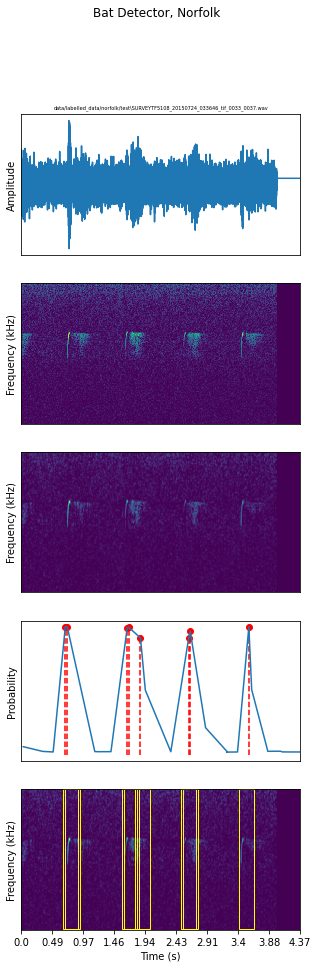


saving results to results/detections/op_file.csv


In [9]:
# params
detection_thresh  = 0.80  # make this smaller if you want more calls detected
do_time_expansion = False  # set to True if audio is not already time expanded
save_res          = True  # save detections

params = DataSetParams()

# load data -
data_dir   = 'data/labelled_data/'+params.test_set+'/test/' # path of the data that we run the model on
op_ann_dir = 'results/detections/' # where we will store the outputs
op_file_name_total = op_ann_dir + 'op_file.csv'
if not os.path.isdir(op_ann_dir):
    os.makedirs(op_ann_dir)

# load gpu lasagne model
model_dir  = 'results/'+params.test_set+'_big_cnn.h5'

det = tf.keras.models.load_model(model_dir)


params.chunk_size = 2*params.window_size

# read audio files
audio_files = glob.glob(data_dir + '*.wav')[:1]
#print(audio_files)
# loop through audio files
results = []
for file_cnt, file_name in enumerate(audio_files):

    file_name_root = file_name[len(data_dir):]
    print('\n', file_cnt+1, 'of', len(audio_files), '\t', file_name_root)

    # read audio file - skip file if cannot read
    read_fail, audio, file_dur, samp_rate, samp_rate_orig = read_audio(file_name,
                            do_time_expansion, params.chunk_size, params.window_size)
    if read_fail:
        continue

    # run detector
    tic = time.time()
    det_time, det_prob, full_time, full_prob = run_detector(det, audio, file_dur, samp_rate, detection_thresh, params)
    toc = time.time()

    print('  detection time', round(toc-tic, 3), '(secs)')
    num_calls = len(det_time)
    print('  ' + str(num_calls) + ' calls found')

    # plot subplots
    font_size = params.axis_font_size

    spectrogram = gen_spectrogram(audio, samp_rate, params.fft_win_length, params.fft_overlap,
                                 crop_spec=params.crop_spec, max_freq=params.max_freq, min_freq=params.min_freq)
    clean_spectrogram = process_spectrogram(spectrogram, denoise_spec=params.denoise, mean_log_mag=params.mean_log_mag, smooth_spec=params.smooth_spec)

    def plot_spectrogram(spectrogram, ax):
        ax.pcolormesh(spectrogram)

    def multiplot_post(ax, title = '', ylab = '', fontsize = font_size, no_x = True, no_y = True):
        if title != '':
            ax.set_title(title, fontsize=fontsize)
        if ylab != '':
            ax.set_ylabel(ylab)
        if no_x:
            ax.set_xticks([])
        if no_y:
            ax.set_yticks([])

    fig, axes = plt.subplots(5, figsize=(5, 15))
    plt.suptitle('Bat Detector, ' + params.test_set.capitalize())
    ## Audio wave
    timescale = np.arange(audio.shape[0])
    axes[0].plot(timescale, audio)
    axes[0].set_xlim([0, audio.shape[0]])
    multiplot_post(axes[0], ylab = 'Amplitude', title = file_name, fontsize = 5)

    # Raw spectrogram
    plot_spectrogram(spectrogram, axes[1])
    multiplot_post(axes[1], ylab = 'Frequency (kHz)')

    # Cleaned spectrogram
    plot_spectrogram(clean_spectrogram, axes[2])
    multiplot_post(axes[2], ylab = 'Frequency (kHz)')

    # Probability of detection
    #axes[3].plot(xnew, full_prob_smooth)
    axes[3].plot(full_time, full_prob)
    axes[3].scatter(det_time, det_prob, c='red')
    axes[3].vlines(det_time, 0, det_prob, colors='red', linestyles='dashed')
    axes[3].set_xlim([0, full_time.max()])
    multiplot_post(axes[3], ylab = 'Probability')

    x_ticks = np.linspace(0, spectrogram.shape[1], num = 10)
    x_labs  = np.round(np.linspace(0, len(audio)/samp_rate, num = 10), 2)

    # Spectrogram with boxes
    plot_spectrogram(clean_spectrogram, axes[4])
    box_times = (det_time/(audio.shape[0]/float(samp_rate)))*(spectrogram.shape[1])
    for timeX in box_times:
        axes[4].add_patch(Rectangle((timeX, 1), 
            width  = params.window_width, 
            height = spectrogram.shape[0]-1, 
            facecolor="none", ec='yellow', lw=1))
        #axes[4].vlines(timeX + params.window_width/2, 0, spectrogram.shape[0], colors='green', linestyles='dashed')
    multiplot_post(axes[4], ylab = 'Frequency (kHz)', no_x = False)
    axes[4].set_xticks(ticks=x_ticks)
    axes[4].set_xticklabels(labels=x_labs)

    plt.xlabel("Time (s)")
    plt.show()

    # save results
    if save_res:
        # return detector results
        pred_classes = np.zeros((len(det_time), 1), dtype=np.int)
        pred_prob    = np.asarray(det_prob)[..., np.newaxis]

        # save to AudioTagger format
        op_file_name = op_ann_dir + file_name_root[:-4] + '-sceneRect.csv'
        wo.create_audio_tagger_op(file_name_root, op_file_name, det_time,
                                  det_prob, pred_classes[:,0], pred_prob[:,0],
                                  samp_rate_orig, np.asarray(['bat']))

        # save as dictionary
        if num_calls > 0:
            res = {'filename':file_name_root, 'time':det_time,
                   'prob':det_prob, 'pred_classes':pred_classes,
                   'pred_prob':pred_prob}
            results.append(res)

# save to large csv
if save_res and (len(results) > 0):
    print('\nsaving results to', op_file_name_total)
    wo.save_to_txt(op_file_name_total, results, np.asarray(['bat']))
else:
    print('no detections to save')

In [13]:
st_poss = np.arange(0, file_dur, 2*params.window_size)
for st_position in st_poss:
    st_pos  = int(st_position*samp_rate)
    en_pos  = int(st_pos + params.chunk_size*samp_rate)
    print(st_position, st_pos, en_pos)

0.0 0 17664
0.46 17664 35328
0.92 35328 52992
1.3800000000000001 52992 70656
1.84 70656 88320
2.3000000000000003 88320 105984
2.7600000000000002 105984 123648
3.22 123648 141312
3.68 141312 158976


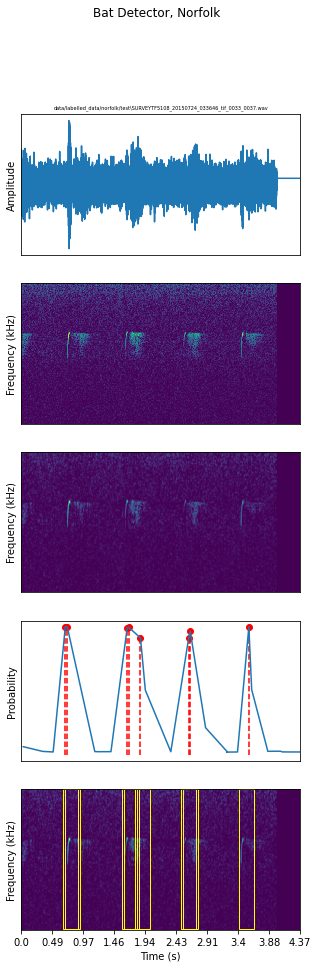

In [15]:
fig, axes = plt.subplots(5, figsize=(5, 15))
plt.suptitle('Bat Detector, ' + params.test_set.capitalize())
## Audio wave
timescale = np.arange(audio.shape[0])
axes[0].plot(timescale, audio)
axes[0].set_xlim([0, audio.shape[0]])
multiplot_post(axes[0], ylab = 'Amplitude', title = file_name, fontsize = 5)

# Raw spectrogram
plot_spectrogram(spectrogram, axes[1])
multiplot_post(axes[1], ylab = 'Frequency (kHz)')

# Cleaned spectrogram
plot_spectrogram(clean_spectrogram, axes[2])
multiplot_post(axes[2], ylab = 'Frequency (kHz)')

# Probability of detection
#axes[3].plot(xnew, full_prob_smooth)
axes[3].plot(full_time, full_prob)
axes[3].scatter(det_time, det_prob, c='red')
axes[3].vlines(det_time, 0, det_prob, colors='red', linestyles='dashed')
axes[3].set_xlim([0, full_time.max()])
multiplot_post(axes[3], ylab = 'Probability')

x_ticks = np.linspace(0, spectrogram.shape[1], num = 10)
x_labs  = np.round(np.linspace(0, len(audio)/samp_rate, num = 10), 2)

# Spectrogram with boxes
plot_spectrogram(clean_spectrogram, axes[4])
box_times = (det_time/(audio.shape[0]/float(samp_rate)))*(spectrogram.shape[1])
for timeX in box_times:
    axes[4].add_patch(Rectangle((timeX, 1), 
        width  = params.window_width, 
        height = spectrogram.shape[0]-1, 
        facecolor="none", ec='yellow', lw=1))
    #axes[4].vlines(timeX + params.window_width/2, 0, spectrogram.shape[0], colors='green', linestyles='dashed')
multiplot_post(axes[4], ylab = 'Frequency (kHz)', no_x = False)
axes[4].set_xticks(ticks=x_ticks)
axes[4].set_xticklabels(labels=x_labs)

plt.xlabel("Time (s)")
plt.show()

In [20]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
fig = make_subplots(rows=5)
fig.add_trace(
    go.Scatter(x=timescale, y=audio), row=1, col=1
)
fig.add_trace(px.imshow(spectrogram).to_image())

In [28]:
dir(px.imshow(spectrogram))

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_annotation_like',
 '_allow_disable_validation',
 '_animation_duration_validator',
 '_animation_easing_validator',
 '_batch_layout_edits',
 '_batch_trace_edits',
 '_bracket_re',
 '_build_dispatch_plan',
 '_build_update_params_from_batch',
 '_config',
 '_data',
 '_data_defaults',
 '_data_objs',
 '_data_validator',
 '_dispatch_layout_change_callbacks',
 '_dispatch_trace_change_callbacks',
 '_filter_by_selector',
 '_frame_objs',
 '_frames_validator',
 '_get_child_prop_defaults',
 '_get_child_props',
 '_get_subplot_coordinates',
 '_get_subplot_rows_columns',
 